Тестовое задание выполнял [Абаполов Филипп](https://vk.com/pheepa) 

![]()

In [1]:
import time
import pickle
import numpy as np

from tqdm import tqdm, tqdm_notebook
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchaudio
import copy

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [2]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
       
DEVICE = torch.device('cuda' if train_on_gpu else 'cpu')

Training on GPU.


In [ ]:
SAMPLE_RATE = 48000
N_FFT = SAMPLE_RATE * 64 // 1000 + 4
HOP_LENGTH = SAMPLE_RATE * 16 // 1000 + 4

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'test']
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SpeechDataset(Dataset):
    """
    Датасет с аудио, который их обрезает/паддит то заданной длины, применяет оконное преобразование Фурье,
    нормализует и приводит к тензору.
    """
    def __init__(self, noisy_files, clean_files, n_fft=64, hop_length=16):
        super().__init__()
        # список файлов для загрузки
        self.noisy_files = sorted(noisy_files)
        self.clean_files = sorted(clean_files)
        self.labels = [path.parent.name for path in self.noisy_files]
        
        # параметры stft
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        # размер датасета
        self.len_ = len(self.noisy_files)
        
        # будем обрезать/паддить waveform аудиофайлов до этого размера
        self.max_len = 165000

    
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        waveform, _ = torchaudio.load(file)
        # transformed = torchaudio.transforms.Resample(48000, 16000)(waveform[0,:].view(1,-1))
        return waveform
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        x_clean = self.load_sample(self.clean_files[index])
        x_noisy = self.load_sample(self.noisy_files[index])
        
        # padding/cutting
        x_clean = self._prepare_sample(x_clean)
        x_noisy = self._prepare_sample(x_noisy)
        
        # оконное преобразование Фурье
        x_noisy_stft = torch.stft(input=x_noisy, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        x_clean_stft = torch.stft(input=x_clean, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        
        return x_noisy_stft, x_clean_stft
        
    def _prepare_sample(self, waveform):
        waveform = waveform.numpy()
        current_len = waveform.shape[1]
        
        output = np.zeros((1, self.max_len), dtype='float32')
        output[0, -current_len:] = waveform[0, :self.max_len]
        output = torch.from_numpy(output)
        
        return output

# dataset

In [ ]:
TEST_NOISY_DIR = Path('noisy_testset_wav')
TEST_CLEAN_DIR = Path('clean_testset_wav')


# TRAIN_NOISY_DIR = Path('/home/philipp/Projects/DCUnet/data/train/noisy_trainset')
# TRAIN_CLEAN_DIR = Path('/home/philipp/Projects/DCUnet/data/train/clean_trainset')

TRAIN_NOISY_DIR = TEST_NOISY_DIR
TRAIN_CLEAN_DIR = TEST_CLEAN_DIR

In [ ]:
test_noisy_files = sorted(list(TEST_NOISY_DIR.rglob('*.wav')))[:100]
test_clean_files = sorted(list(TEST_CLEAN_DIR.rglob('*.wav')))[:100]

train_noisy_files = sorted(list(TRAIN_NOISY_DIR.rglob('*.wav')))
train_clean_files = sorted(list(TRAIN_CLEAN_DIR.rglob('*.wav')))

In [ ]:
test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)
train_dataset = SpeechDataset(train_noisy_files, train_clean_files, N_FFT, HOP_LENGTH)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=4)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

In [ ]:
x_n, x_c = iter(test_loader).next()

[2, 1, 1539, 214, 2])

In [13]:
x_n.shape

torch.Size([8, 1, 1539, 214, 2])

In [14]:
x_n.flatten(1).shape

torch.Size([8, 658692])

In [15]:
x_n.max()

tensor(5.4403)

In [ ]:
class CConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        
        self.real_conv = nn.Conv2d(in_channels=self.in_channels, 
                                   out_channels=self.out_channels, 
                                   kernel_size=self.kernel_size, 
                                   padding=self.padding, 
                                   stride=self.stride)
        
        self.im_conv = nn.Conv2d(in_channels=self.in_channels, 
                                 out_channels=self.out_channels, 
                                 kernel_size=self.kernel_size, 
                                 padding=self.padding, 
                                 stride=self.stride)
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_conv.weight)
        nn.init.xavier_uniform_(self.im_conv.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        c_real = self.real_conv(x_real) - self.im_conv(x_im)
        c_im = self.im_conv(x_real) + self.real_conv(x_im)
        
        output = torch.stack([c_real, c_im], dim=-1)
        return output

In [ ]:
class CConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding=0, padding=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.output_padding = output_padding
        self.padding = padding
        self.stride = stride
        
        self.real_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding,
                                            padding=self.padding,
                                            stride=self.stride)
        
        self.im_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding, 
                                            padding=self.padding,
                                            stride=self.stride)
        
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.im_convt.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        ct_real = self.real_convt(x_real) - self.im_convt(x_im)
        ct_im = self.im_convt(x_real) + self.real_convt(x_im)
        
        output = torch.stack([ct_real, ct_im], dim=-1)
        return output

In [ ]:
class CBatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        
        self.real_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.im_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                    affine=self.affine, track_running_stats=self.track_running_stats) 
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        n_real = self.real_b(x_real)
        n_im = self.im_b(x_im)  
        
        output = torch.stack([n_real, n_im], dim=-1)
        return output

In [ ]:
class Encoder(nn.Module):
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45, padding=(0,0)):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding

        self.cconv = CConv2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconv(x)
        normed = self.cbn(conved)
        acted = self.leaky_relu(normed)
        
        return acted

In [ ]:
class Decoder(nn.Module):
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45,
                 output_padding=(0,0), padding=(0,0), last_layer=False):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_padding = output_padding
        self.padding = padding
        
        self.last_layer = last_layer
        
        self.cconvt = CConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, output_padding=self.output_padding, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconvt(x)
        
        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag
            
        return output

In [ ]:
class DCUnet10(nn.Module):
    def __init__(self, n_fft=64, hop_length=16):
        super().__init__()
        
        # for istft
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        # downsampling/encoding
        self.downsample0 = Encoder(filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45)
        self.downsample1 = Encoder(filter_size=(7,5), stride_size=(2,2), in_channels=45, out_channels=90)
        self.downsample2 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample3 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample4 = Encoder(filter_size=(5,3), stride_size=(2,1), in_channels=90, out_channels=90)
        
        # upsampling/decoding
        self.upsample0 = Decoder(filter_size=(5,3), stride_size=(2,1), in_channels=90, out_channels=90)
        self.upsample1 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90)
        self.upsample2 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90)
        self.upsample3 = Decoder(filter_size=(7,5), stride_size=(2,2), in_channels=180, out_channels=45)
        self.upsample4 = Decoder(filter_size=(7,5), stride_size=(2,2), in_channels=90, output_padding=(0,1),
                                 out_channels=1, last_layer=True)
        
        
    def forward(self, x, is_istft=True):
        # downsampling/encoding
        d0 = self.downsample0(x)
        d1 = self.downsample1(d0) 
        d2 = self.downsample2(d1)        
        d3 = self.downsample3(d2)        
        d4 = self.downsample4(d3)
        
        # upsampling/decoding
        u0 = self.upsample0(d4)
        c0 = torch.cat((u0, d3), dim=1)
        
        u1 = self.upsample1(c0)
        c1 = torch.cat((u1, d2), dim=1)
        
        u2 = self.upsample2(c1)
        c2 = torch.cat((u2, d1), dim=1)
        
        u3 = self.upsample3(c2)
        c3 = torch.cat((u3, d0), dim=1)
        
        u4 = self.upsample4(c3)
        
        # u4 - the mask
        output = u4 * x
        # if is_istft:
        output = torchaudio.functional.istft(output, n_fft=self.n_fft, hop_length=self.hop_length, normalized=True)
        
        return output

In [ ]:
class sdr_loss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
    def forward(self, y_pred, y_true):
        num = (y_pred * y_true).sum(dim=1)
        den = torch.norm(y_pred, dim=1) * torch.norm(y_true, dim=1) + self.eps
        return (-1) * num / den

In [ ]:
class WSDR_loss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.sdr = sdr_loss(eps)
    def forward(self, x_, y_pred_, y_true_):
        y_true = torchaudio.functional.istft(y_true_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
        x = torchaudio.functional.istft(x_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
        y_pred = y_pred_.flatten(1)
        y_true = y_true.flatten(1)
        x = x.flatten(1)
        # plt.plot(y_pred[0].view(-1).detach().cpu().numpy())
        # plt.show()
        # plt.plot(y_true[0].view(-1).detach().cpu().numpy())
        # plt.show()
        z_pred = x - y_pred
        z_true = x - y_true
        sdr_y = self.sdr(y_pred, y_true)
        sdr_z = self.sdr(z_pred, z_true)

        alpha = (torch.norm(y_true, dim=1) ** 2) / ((torch.norm(y_true, dim=1) ** 2) * (torch.norm(z_true, dim=1) ** 2) + self.eps)

        res = alpha * sdr_y + (1 - alpha) * sdr_z

        return res.mean()

In [ ]:
class mse_loss(nn.Module):
  def __init__(self, eps=1e-8):
      super().__init__()
      self.eps = eps
  def forward(self, y_pred_, y_true_):
      y_pred__ = torchaudio.functional.istft(y_pred_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
      y_true__ = torchaudio.functional.istft(y_true_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
      y_pred = y_pred__.flatten(1)
      y_true = y_true__.flatten(1)
      res = ((y_pred - y_true) ** 2).sum(dim=1)
      return res.mean()

In [ ]:
def train(net, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs, train_on_gpu=True):
    net.train()
    losses = []
    val_avg_losses = []


    if(train_on_gpu):
        net = net.cuda()
        
    for e in tqdm(range(epochs)):
        # batch loop
        counter = 0
        val_losses_ep = []
        for noisy_x, clean_x in tqdm(train_loader):
            counter += 1
            
            if(train_on_gpu):
                noisy_x, clean_x = noisy_x.cuda(), clean_x.cuda()

            # zero  gradients
            net.zero_grad()
            # get the output from the model
            pred_x = net(noisy_x)
            loss = loss_fn(noisy_x, pred_x, clean_x)
            print(loss.item())
            
            losses.append(loss.item())
            loss.backward()
            
            optimizer.step()

            # loss stats
            if counter % 10 == 0:
                val_losses = []

                # Get validation loss
                net.eval()
                for noisy_val, clean_val in test_loader:

                    if(train_on_gpu):
                        noisy_val, clean_val = noisy_val.cuda(), clean_val.cuda()

                    pred_val = net(noisy_val)

                    # calculate the loss
                    val_loss = loss_fn(noisy_val, pred_val, clean_val)
                    val_losses.append(val_loss.item())

                net.train()
                val_losses_ep.append(np.mean(val_losses))
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(val_losses)))
      
        if scheduler:
          scheduler.step()
        val_avg_losses.append(np.mean(val_losses_ep))
    return losses, val_avg_losses
    

In [30]:
import gc
gc.collect()

1087

In [ ]:
dcunet10 = DCUnet10(N_FFT, HOP_LENGTH)

In [ ]:
loss_fn = WSDR_loss(eps=1e-8)
optimizer = torch.optim.SGD(dcunet10.parameters(), lr=1e-7)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [ ]:
tl, vl = train(dcunet10, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs=20)

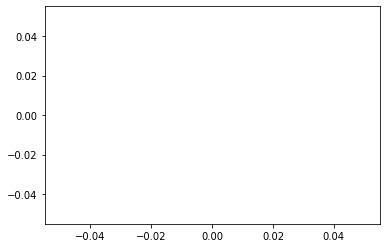

In [38]:
plt.plot(vl)

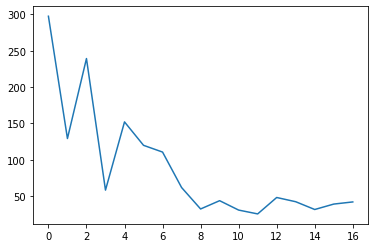

In [82]:
plt.plot(ll)

In [52]:
x_est = dcunet10(x_n.cuda(), is_istft=True)

RuntimeError: ignored

In [ ]:
dcunet10.eval()

In [203]:
x_est[0].shape

torch.Size([1, 164436])

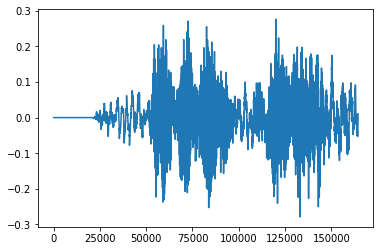

In [53]:
plt.plot(x_est[0].view(-1).detach().cpu().numpy())

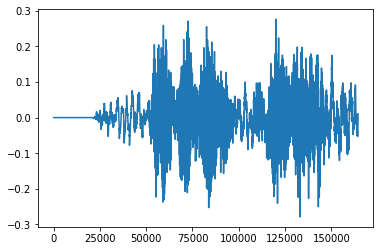

In [54]:
plt.plot(x_est[0].view(-1).detach().cpu().numpy())

In [55]:
x_n.shape

torch.Size([8, 1, 1539, 214, 2])

In [ ]:
x_n_v = torchaudio.functional.istft(x_n, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)

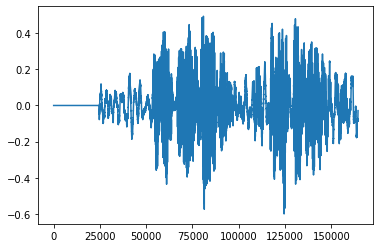

In [57]:
plt.plot(x_n_v[0].view(-1).detach().numpy())

In [ ]:
x_c_v = torchaudio.functional.istft(x_c, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)

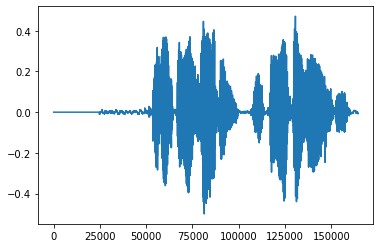

In [59]:
plt.plot(x_c_v[0].view(-1).detach().numpy())